# House Prices Estimator

__Note:__ It's a competition from __Kaggle.com__ and the input data was retrieved from there.


## Data Analysis

First off we're going to load the training and test dataset. A 'data' variable is created from both datasets and the number of training samples are saved it for future uses.

In [1]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]

#print some of them
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [2]:
# remove the Id feature, because is not useful for price predictions
data.drop(['Id'],1, inplace=True);

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [4]:
print("Size training: {}".format(train.shape[0]))
print("Size testing: {}".format(test.shape[0]))

Size training: 1460
Size testing: 1459


### First problem
* The training and test datasets have almost the __same size__ so it's going to be difficult to get good predictions. Worst if we want to take a part of the training set as the validation dataset. It would be desirable to have more training samples.

### Selecting _only_ numeric columns (by now) 

Probably the non numeric features have a lot of useful information, but for our study purposes we are only going to get the numeric features and see what happens and if we are able to get a good model predictor.

In [5]:
datanum = data.select_dtypes([np.number])

### Find if there's null values

In [6]:
datanum.columns[datanum.isnull().any()].tolist()

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'SalePrice',
 'TotalBsmtSF']

In [7]:
#number of row without NaN
print(datanum.shape[0] - datanum.dropna().shape[0])

1798


In [8]:
#list of columns with NaN
datanum.columns[datanum.isnull().any()].tolist()

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'SalePrice',
 'TotalBsmtSF']

_NaN_ values will be filled with the mean of the feature they belong. It's a good way to replace _NaN_ values in order to avoid modifying the distribution of the feature but it could cheat the predicted results. We'll assume that.

In [9]:
#Filling with the mean
datanum_no_nan = datanum.fillna(datanum.dropna().mean())

#check
datanum_no_nan.columns[datanum_no_nan.isnull().any()].tolist()

[]

### Normalizing

This process is useful when we are dealing with neural networs. At this moment we don't know what kind of model we are going to implement, so the data will be normalized.

Also the normalization bring us the possibility of managing smaller numbers which improves the speed in the calculations.

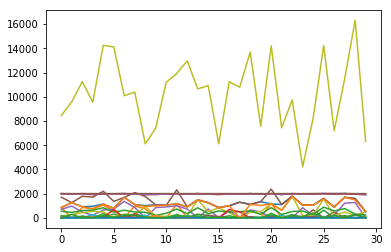

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# All numeric features except the 'SalePrice'
datanum_no_nan.drop(['SalePrice'], axis=1).head(30).plot(legend=False);

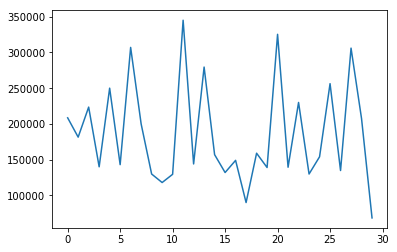

In [11]:
# SalePrice
datanum_no_nan['SalePrice'].head(30).plot(legend=False);

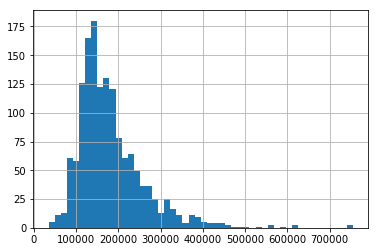

In [12]:
# Showing SalePrice distribution
data.SalePrice.hist(bins=50)

The 'SalePrice' has a __skewed graph__. We can stabilize it applying a logarithmic operation because we know that all the values are positive.

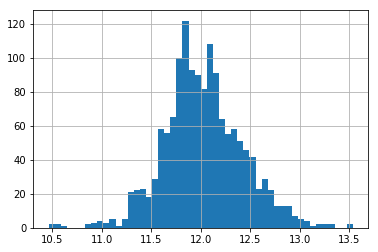

In [13]:
# Transforming to non-skewed SalePrice
data.SalePrice = data.SalePrice.apply(np.log)
data.SalePrice.hist(bins=50)

In [14]:
#Squeeze the data using standard scaler:  z = (x - mean)/ std
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns = datanum_no_nan.columns.drop('SalePrice')

print("Features: {}".format(columns))

Features: Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')


Train shape: (2919, 37)


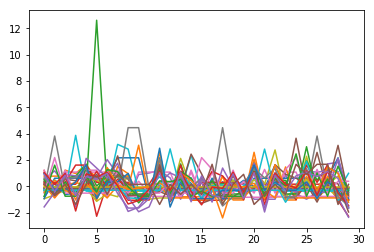

In [15]:
#make a copy
data_norm = datanum_no_nan

data_norm[columns] = scaler.fit_transform(datanum_no_nan[columns])
print("Train shape: {}".format(data_norm.shape))

data_norm.drop(['SalePrice'], axis=1).head(30).plot(legend=False);

### Selecting good features...

There are a lot of features in this dataset so we are going to select only the most correlated features with the 'SalePrice'.
With the following query we can see that the ten first features have a good correlation.

In [16]:
# Correlation features
data_norm.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.547865
GrLivArea       0.518693
GarageCars      0.444010
GarageArea      0.437270
TotalBsmtSF     0.431030
1stFlrSF        0.421430
FullBath        0.394865
TotRmsAbvGrd    0.388821
YearBuilt       0.368417
Name: SalePrice, dtype: float64

In [17]:
high_corr_feat_names = data_norm.corr()['SalePrice'].sort_values(ascending=False).head(10).axes[0].tolist()
high_corr_feat_names.remove('SalePrice')
data_norm_high_corr = data_norm[high_corr_feat_names]

#### Showing relationships

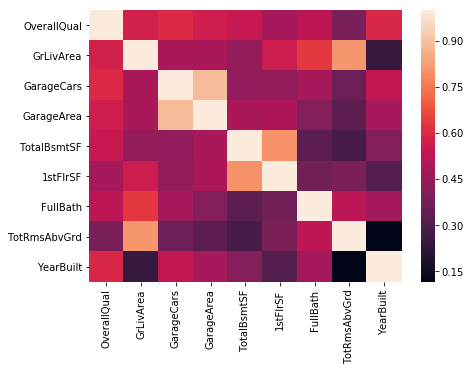

In [18]:
#heatmap between the most correlated features
import seaborn as sns

fig = plt.figure(figsize=(7, 5))
sns.heatmap(data_norm_high_corr.corr());

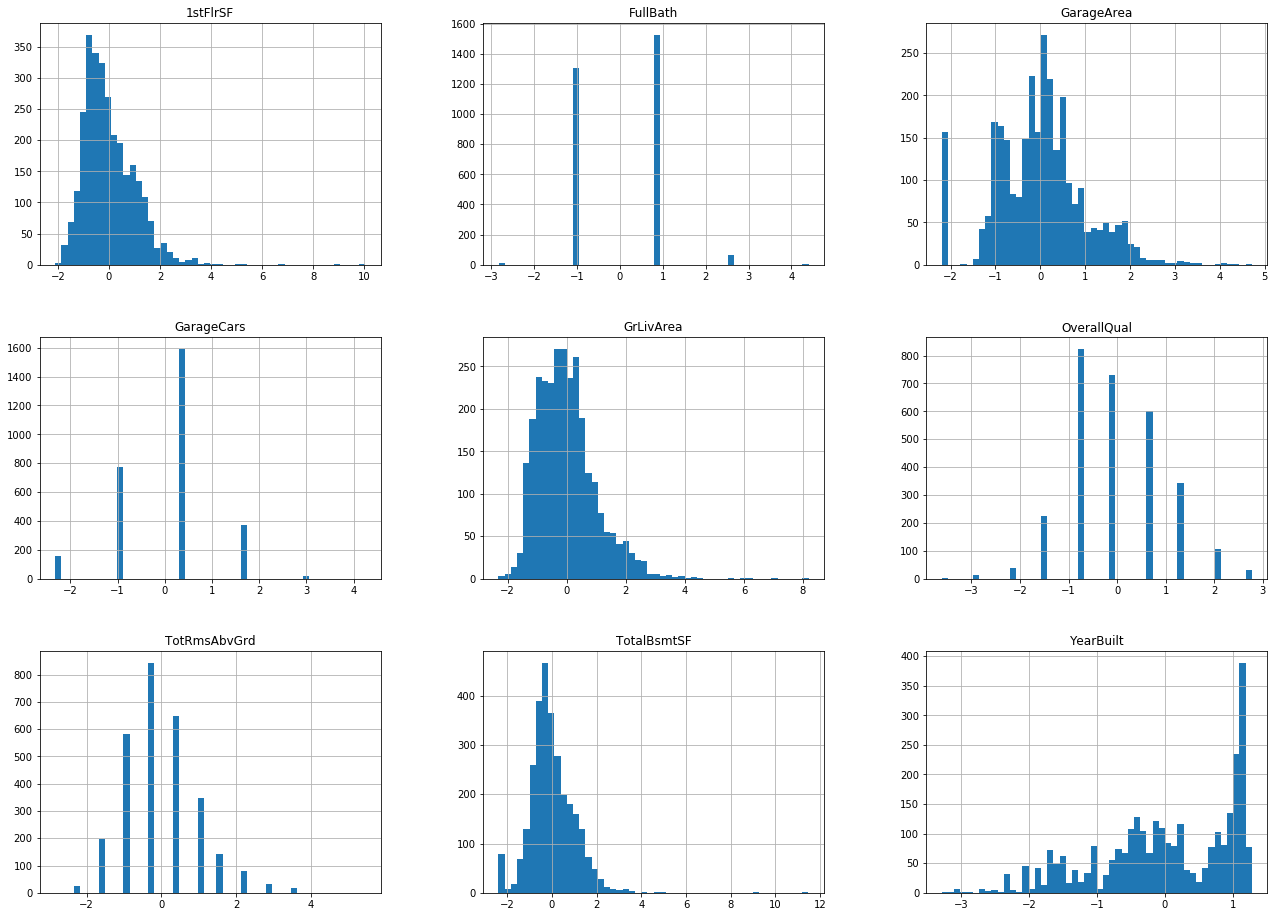

In [19]:
#plotting distributions of numeric features
data_norm_high_corr.hist(bins=50, figsize=(22,16));

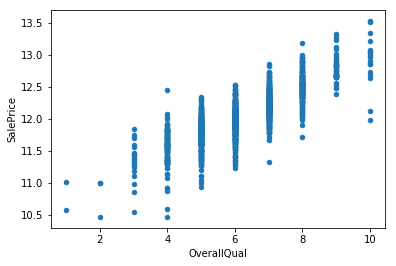

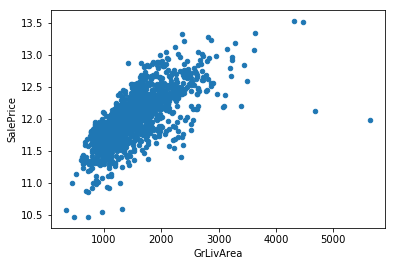

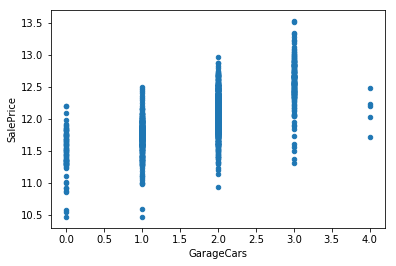

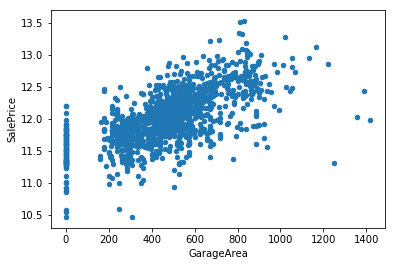

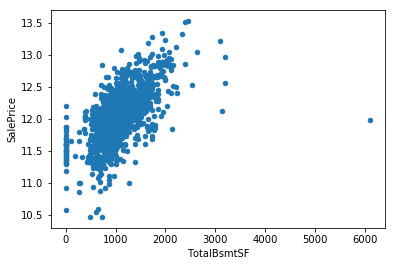

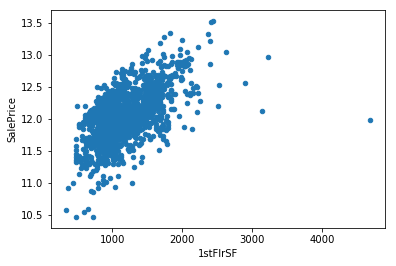

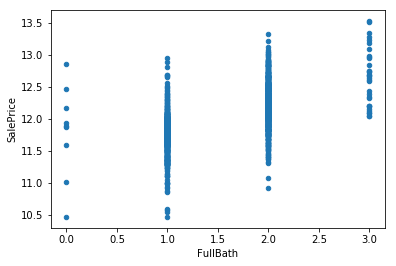

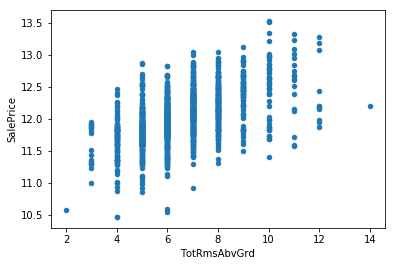

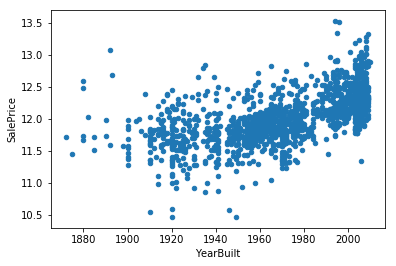

In [20]:
#Relationships between correlated features

for feature in high_corr_feat_names:
    data.plot.scatter(feature, 'SalePrice');

### Splitting dataset in train and test

Now we have to recover the datasets for training and test from our current preprocessed dataset. We'll use the 'train_samples' variable that we saved in advance to split it in these two.

The KFold object is also defined and instanced.

#### KFold

In [21]:
from sklearn.model_selection import KFold

y = np.array(data['SalePrice'])
X = np.array(data_norm_high_corr)

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

print("Shape X train: {}".format(X_train.shape))
print("Shape y train: {}".format(y_train.shape))
print("Shape X test: {}".format(X_test.shape))
print("Shape y test: {}".format(y_test.shape))

kf = KFold(n_splits=3, random_state=9, shuffle=True)
print(kf)

Shape X train: (1460, 9)
Shape y train: (1460,)
Shape X test: (1459, 9)
Shape y test: (1459,)
KFold(n_splits=3, random_state=9, shuffle=True)


#### Anomaly Detection

Besides it's important to take into account the possible anomalies we can found in the training dataset. For this reason it's going to be calculated a small number of them to be removed.

In [22]:
#plotting PCA
from sklearn.decomposition import PCA

def getX_PCA(X):
    pca = PCA(n_components=1)
    return pca.fit(X).transform(X)
    
def plotPCA(X, y):
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    plt.plot(X_r, y, 'x')

Number samples: 1314


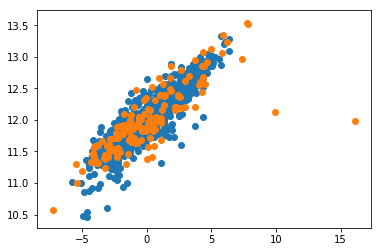

In [23]:
from sklearn.covariance import EllipticEnvelope

# fit the model
ee = EllipticEnvelope(contamination=0.1,
                      assume_centered=True,
                      random_state=9)
ee.fit(X_train)
pred = ee.predict(X_train)

X_train_orig = X_train
y_train_orig = y_train

X_bad = X_train[pred != 1]
y_bad = y_train[pred != 1]
X_train = X_train[pred == 1]
y_train = y_train[pred == 1]
print("Number samples: {}".format(X_train.shape[0]))

#after removing anomalies
plt.scatter(getX_PCA(X_train), y_train)
plt.scatter(getX_PCA(X_bad), y_bad)

#### Polynomial Features

It could be interesting to extract more information between the current features. Actually we are only working with a small number of the original so we can afford to get polynomial features from them. Obviously that will increase the number of final features.

In [24]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = preprocessing.PolynomialFeatures(degree=2)

X_train_orig = poly.fit_transform(X_train_orig)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

### Models

_*__Note__:_ a logarithmic function has been applied to 'SalePrice' so using the _mean squared error_ directly we will obtain the _RMSLE_.

0) Training error: 0.15  Validation error: 0.15 Score: 0.83
1) Training error: 0.14  Validation error: 0.16 Score: 0.82
2) Training error: 0.14  Validation error: 0.16 Score: 0.84
Training score: 0.7990
RMSLE: 0.1790


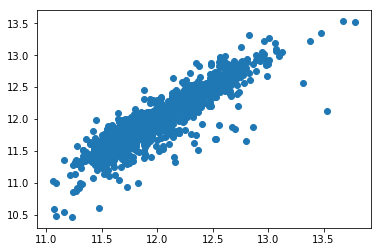

In [25]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()

#
batch = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    lr.fit(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, lr.predict(X_t))**0.5
    v_error = mean_squared_error(y_v, lr.predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, lr.score(X_v, y_v)))
    batch += 1

#Scores
print("Training score: {:.4f}".format(lr.score(X_train_orig, y_train_orig)))
#RMSLE
rmsle = mean_squared_error(y_train_orig, lr.predict(X_train_orig))**0.5
print("RMSLE: {:.4f}".format(rmsle))

# Plotting the results
plt.scatter(lr.predict(X_train_orig), y_train_orig)

0) Training error: 0.00  Validation error: 0.19 Score: 0.72
1) Training error: 0.14  Validation error: 0.01 Score: 1.00
2) Training error: 0.14  Validation error: 0.00 Score: 1.00
Training score: 0.8579
RMSLE: 0.1505


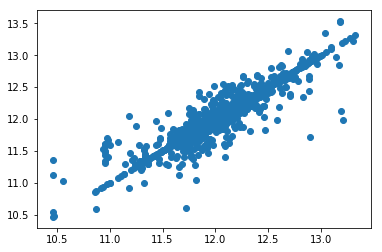

In [26]:
# Gradient boosting
from sklearn import ensemble

params = {'n_estimators': 100, 'max_depth': X_train.shape[1], 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'ls', 'random_state':9, 'warm_start':True}

gbr = ensemble.GradientBoostingRegressor(**params)

batch = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    gbr.fit(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, gbr.predict(X_t))**0.5
    v_error = mean_squared_error(y_v, gbr.predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, gbr.score(X_v, y_v)))
    batch += 1

#Scores
print("Training score: {:.4f}".format(gbr.score(X_train_orig, y_train_orig)))
#RMSLE
rmsle = mean_squared_error(y_train_orig, gbr.predict(X_train_orig))**0.5
print("RMSLE: {:.4f}".format(rmsle))

# Plotting the results
plt.scatter(gbr.predict(X_train_orig), y_train_orig)

0) Training error: 0.01  Validation error: 0.17 Score: 0.78
1) Training error: 0.01  Validation error: 0.16 Score: 0.83
2) Training error: 0.01  Validation error: 0.16 Score: 0.84
Training score: 0.9049
RMSLE: 0.1232


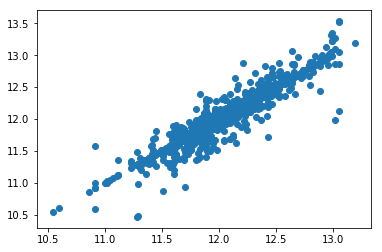

In [27]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=X_train.shape[1]),
                        n_estimators=100, random_state=9)

batch = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    abr.fit(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, abr.predict(X_t))**0.5
    v_error = mean_squared_error(y_v, abr.predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, abr.score(X_v, y_v)))
    batch += 1

#Scores
print("Training score: {:.4f}".format(abr.score(X_train_orig, y_train_orig)))
#RMSLE
rmsle = mean_squared_error(y_train_orig, abr.predict(X_train_orig))**0.5
print("RMSLE: {:.4f}".format(rmsle))

# Plotting the results
plt.scatter(abr.predict(X_train_orig), y_train_orig)

### Stacked Model

In order to improve the previous predictions it's going to create a simple __stacked model__ with the following architecture:

- __Level1__ is composed of previous trained LinearRegressor, GradiendBoostingRegressor and AdaBoostRegressor
- The outcome of this __level1__ layer is passed to a LinearRegressor.


0) Training error: 0.07  Validation error: 0.08 Score: 0.96
1) Training error: 0.07  Validation error: 0.07 Score: 0.96
2) Training error: 0.07  Validation error: 0.07 Score: 0.96
RMSLE: 0.1111


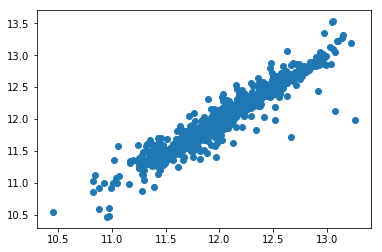

In [28]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
sclr = preprocessing.StandardScaler()

def features_level1(X):
    X0 = lr.predict(X)
    X1 = gbr.predict(X)
    X2 = abr.predict(X)
    Xt = np.array([X0, X1, X2]).T
    return sclr.fit_transform(Xt)

def stack_training(X, y):
    slr.fit(features_level1(X), y)

def stack_predict(X):
    return slr.predict(features_level1(X))

def stack_score(X, y):
    return slr.score(features_level1(X), y)

#
batch = 0
kf = KFold(n_splits=3, random_state=9)

for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    stack_training(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, stack_predict(X_t))**0.5
    v_error = mean_squared_error(y_v, stack_predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, stack_score(X_v, y_v)))
    batch += 1

rmsle = mean_squared_error(y_train_orig, stack_predict(X_train_orig))**0.5
print("RMSLE: {:.4f}".format(rmsle))

# Plotting the results
plt.scatter(stack_predict(X_train_orig), y_train_orig)

### Averaged Model

Same as before, the __averaged model__ tries to improve the predictions results. In this case the architecture is indeed much simpler. The final prediction is averaged with the outcomes of the LinearRegressor, GradientBoostingRegressor and AdaBoostRegressor.

RMSLE: 0.118


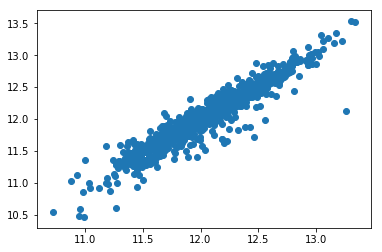

In [29]:
def avg_predict(X):
    return (lr.predict(X) + gbr.predict(X) + abr.predict(X))/3

predictions = avg_predict(X_train_orig)
RMSLE = mean_squared_error(y_train_orig, predictions)**0.5

print("RMSLE: {:.3f}".format(RMSLE))

# Plotting the results
plt.scatter(avg_predict(X_train_orig), y_train_orig)

### Evaluation

In [30]:
from sklearn.metrics import mean_squared_error
import random

RMSLE_lr = mean_squared_error(y_train, lr.predict(X_train))**0.5
RMSLE_gbr = mean_squared_error(y_train, gbr.predict(X_train))**0.5
RMSLE_abr = mean_squared_error(y_train, abr.predict(X_train))**0.5
RMSLE_avg = mean_squared_error(y_train, stack_predict(X_train))**0.5
RMSLE_stack = mean_squared_error(y_train, avg_predict(X_train))**0.5

print("RMSLE lr: {:.3f}".format(RMSLE_lr))
print("RMSLE gbr: {:.3f}".format(RMSLE_gbr))
print("RMSLE abr: {:.3f}".format(RMSLE_abr))
print("RMSLE average: {:.3f}".format(RMSLE_avg))
print("RMSLE stacked: {:.3f}".format(RMSLE_stack))

RMSLE lr: 0.149
RMSLE gbr: 0.111
RMSLE abr: 0.095
RMSLE average: 0.071
RMSLE stacked: 0.089


## Get Predictions

In [31]:
import os

predict = avg_predict(X_test)
#predict = stack_predict(X_test)
#predict = lr.predict(X_test)

#predictions are logs, return to the value
predict = np.exp(predict)

file = "Id,SalePrice" + os.linesep

startId = 1461
for i in range(len(X_test)):
    file += "{},{}".format(startId, (int)(predict[i])) + os.linesep
    startId += 1

#print(file)

In [32]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)